<h1 style="font-size:35px; text-align:center">Inject kicks into orbits of disrupted binaries</h1>

In [33]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
import gala as ga
import pandas as pd
import os

import astropy.coordinates as coord
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
from astropy.table import Table

import sys
sys.path.append("../src/helpers")
import kicks, galaxy

In [34]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

## Investigate how binary interactions could influence things

**Mathieu says:** My idea here is

1. assume that the Zari+21 stars (present day massive stars in the Galaxy) are representative of the parent population of the BH (we could call this the "young BH scenario")
2. assume that most massive stars are born in binary system. Presumably this is not false for the Zari sample, modulo selection effects and Gaia explicitly not releasing "non-single stars" yet, but at least presumably the orbits of those field binaries would not be different than Zari+21.

With these two assumptions, I then propose the following exercise: shoot along the galaxy (with Gala) one binary system. For now assume binary evolution and Galactic dynamics are independent (this might not be true for very wide binaries or very deep in the galactic center): from the pop synth. you known the age at the first SN/BH formation, from gala (assuming initial conditions randomly sampled from the Zari+21 distributions) you know the position and velocity, from pop. synth you know the kick, so you can perturb the orbit and obtain the BH orbit

**Tom thoughts:** Okay so we need these variables (where we get them from in parentheses): initial position (drawn from Frankel model), initial velocity (from Zari stars), birth time (drawn from Frankel model), lifetime (Mathieu's table), SN kick (Mathieu's table), kick angle (randomly drawn). After that it should be fairly simple to do.

## Get Mathieu's stars

In [3]:
# avoid reading the ascii file more than once
if os.path.isfile("../src/data/renzo.fiducial.sn.h5"):
    renzo_df = pd.read_hdf("../src/data/renzo.fiducial.sn.h5", key="df")
else:
    with open("../src/data/renzo.fiducial.sn.dat") as f:
        for i in range(57):
            f.readline().rstrip()
        columns = f.readline().rstrip().split()[1:]

    renzo = np.genfromtxt("../src/data/renzo.fiducial.sn.dat", skip_header=58)

    renzo_df = pd.DataFrame(renzo, columns=columns)
    renzo_df.to_hdf("../src/data/renzo.fiducial.sn.h5", key="df")

In [35]:
# mask out anything that's not a BH disrupted in the first SN
disrupted_BHs = np.logical_and.reduce((np.logical_and(renzo_df["e_preCC"] >= 0, renzo_df["e_preCC"] <= 1),
                                       np.logical_or(renzo_df["e_postCC"] < 0, renzo_df["e_postCC"] > 1),
                                       renzo_df["type1postCC"] == 14))

In [36]:
# grab the velocity of the BH and the time at which it occurs
v_BH = renzo_df["v1postCC"][disrupted_BHs].values * u.km / u.s
t_kick = renzo_df["t_explosion"][disrupted_BHs].values * u.Myr

n_BHs = len(v_BH)

## Setup the galaxy positions

In [37]:
# we only want low-alpha disc stars, randomly draw some of them
tau, D, Z, pos, wc = galaxy.simulate_mw(n_BHs, ret_pos=True, components=["low_alpha_disc"], masses=[1])
R, z, theta = pos
x = R * np.cos(theta)
y = R * np.sin(theta)

# turn positions in astropy coordinate
# c_gal = coord.SkyCoord(
#     x=x,
#     y=y,
#     z=z,
#     frame="galactocentric"
# )

# # find out which are within 0.5kpc of the BH
# c_BH = coord.SkyCoord(
#     ra="17:51:40.2082",
#     dec="-29:53:26.502",
#     unit=(u.hourangle, u.degree),
#     distance=1.58*u.kpc,
# )

# close_in_galaxy = c_gal[c_gal.separation_3d(c_BH) < 0.2 * u.kpc]

## Get the Zari stars that have velocities

In [38]:
galcen_frame = coord.Galactocentric()

zari_gaia = Table.read("../src/data/zari_matching.dat", format="ascii")

zari_coords = coord.SkyCoord(
    ra=zari_gaia["ra"],
    dec=zari_gaia["dec"],
    unit=(u.deg, u.deg),
    distance=coord.Distance(parallax=zari_gaia["parallax"].data * u.mas),
    pm_ra_cosdec=zari_gaia["pmra"].data * u.mas/u.yr * np.cos(zari_gaia["dec"].data * u.deg),
    pm_dec=zari_gaia["pmdec"].data * u.mas/u.yr,
    radial_velocity=zari_gaia["dr2_radial_velocity"].data * u.km/u.s
).transform_to(galcen_frame)[np.logical_not(zari_gaia["dr2_radial_velocity"].mask)]

## Get it all in Gala language

In [40]:
# make some random indices so the BHs from the Zari velocities
rnd_vel_index = np.random.randint(0, len(zari_coords), size=n_BHs)

In [39]:
# stick it all together for Gala
coords = coord.SkyCoord(
    x=x,
    y=y,
    z=z,
    v_x=zari_coords.v_x[rnd_vel_index],
    v_y=zari_coords.v_y[rnd_vel_index],
    v_z=zari_coords.v_z[rnd_vel_index],
    frame=galcen_frame
)

w0s = ga.dynamics.PhaseSpacePosition(coords.data)

In [41]:
# choose a smaller random sample for testing
random_sample = np.random.choice(n_BHs, replace=False, size=10)

small_w0s = w0s[random_sample]
small_tau = tau[random_sample]
small_kick = v_BH[random_sample]
small_t_kick = t_kick[random_sample]

In [42]:
# calculate the orbits
orbits = [kicks.integrate_orbits_with_kicks(small_w0s[i],
                                            dt=1 * u.Myr,
                                            t1=0 * u.Gyr,
                                            t2=small_tau[i],
                                            kicks=[small_kick[i]],
                                            kick_times=[small_t_kick[i]]) for i in range(len(small_tau))]

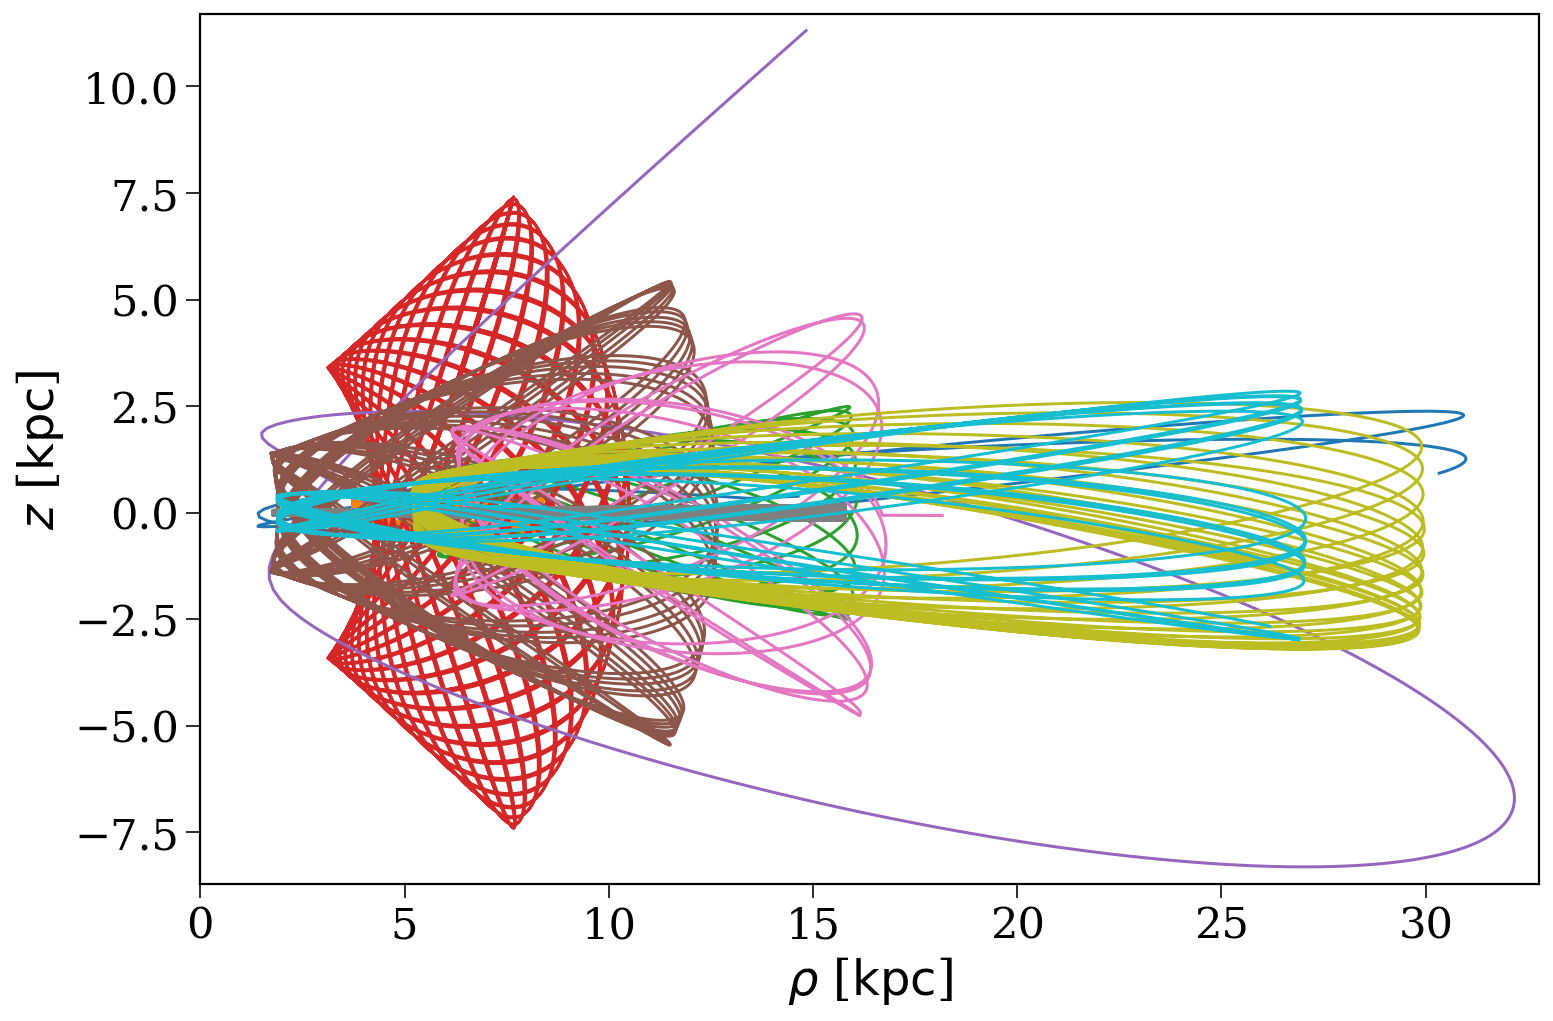

In [45]:
fig, ax = plt.subplots()

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for orbit in orbits:
    orbit.cylindrical.plot(["rho", "z"], axes=ax)
    
    new_x = ax.get_xlim()
    new_y = ax.get_ylim()
    
    xlim = (min(new_x[0], xlim[0]), max(new_x[1], xlim[1]))
    ylim = (min(new_y[0], ylim[0]), max(new_y[1], ylim[1]))
    
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()